In [460]:
#pip install tensorflow

In [461]:
#pip install --upgrade pip

In [462]:
%matplotlib inline
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("prepared_with_events_JPYUSD.csv")


In [463]:
df.head()

,Date,Open,High,Low,Close,Adj Close,USGoldSteinScale,USNumMentions,JPGoldSteinScale,JPNumMentions
0,2005-05-01,105.120003,105.410004,104.900002,105.099998,105.099998,0.0,0.0,0.0,0.0
1,2005-05-02,105.120003,105.410004,104.900002,105.099998,105.099998,-10.0,10.0,7.0,10.0
2,2005-05-03,105.089996,105.320000,104.839996,104.870003,104.870003,0.0,0.0,0.0,0.0
3,2005-05-04,104.849998,104.989998,104.199997,104.519997,104.519997,0.0,0.0,7.0,10.0
4,2005-05-05,104.510002,104.669998,104.250000,104.510002,104.510002,0.0,0.0,7.0,10.0


In [464]:
df.Date=  pd.to_datetime(df['Date'])

In [465]:
df.head()

,Date,Open,High,Low,Close,Adj Close,USGoldSteinScale,USNumMentions,JPGoldSteinScale,JPNumMentions
0,2005-05-01,105.120003,105.410004,104.900002,105.099998,105.099998,0.0,0.0,0.0,0.0
1,2005-05-02,105.120003,105.410004,104.900002,105.099998,105.099998,-10.0,10.0,7.0,10.0
2,2005-05-03,105.089996,105.320000,104.839996,104.870003,104.870003,0.0,0.0,0.0,0.0
3,2005-05-04,104.849998,104.989998,104.199997,104.519997,104.519997,0.0,0.0,7.0,10.0
4,2005-05-05,104.510002,104.669998,104.250000,104.510002,104.510002,0.0,0.0,7.0,10.0


In [466]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6635 entries, 0 to 6634
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              6635 non-null   datetime64[ns]
 1   Open              6635 non-null   float64       
 2   High              6635 non-null   float64       
 3   Low               6635 non-null   float64       
 4   Close             6635 non-null   float64       
 5   Adj Close         6635 non-null   float64       
 6   USGoldSteinScale  6635 non-null   float64       
 7   USNumMentions     6635 non-null   float64       
 8   JPGoldSteinScale  6635 non-null   float64       
 9   JPNumMentions     6635 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 518.5 KB


In [467]:
df.head()

,Date,Open,High,Low,Close,Adj Close,USGoldSteinScale,USNumMentions,JPGoldSteinScale,JPNumMentions
0,2005-05-01,105.120003,105.410004,104.900002,105.099998,105.099998,0.0,0.0,0.0,0.0
1,2005-05-02,105.120003,105.410004,104.900002,105.099998,105.099998,-10.0,10.0,7.0,10.0
2,2005-05-03,105.089996,105.320000,104.839996,104.870003,104.870003,0.0,0.0,0.0,0.0
3,2005-05-04,104.849998,104.989998,104.199997,104.519997,104.519997,0.0,0.0,7.0,10.0
4,2005-05-05,104.510002,104.669998,104.250000,104.510002,104.510002,0.0,0.0,7.0,10.0


In [468]:
df = df.set_index("Date")

In [469]:
df.head()

,Open,High,Low,Close,Adj Close,USGoldSteinScale,USNumMentions,JPGoldSteinScale,JPNumMentions
Date,,,,,,,,,
2005-05-01,105.120003,105.410004,104.900002,105.099998,105.099998,0.0,0.0,0.0,0.0
2005-05-02,105.120003,105.410004,104.900002,105.099998,105.099998,-10.0,10.0,7.0,10.0
2005-05-03,105.089996,105.320000,104.839996,104.870003,104.870003,0.0,0.0,0.0,0.0
2005-05-04,104.849998,104.989998,104.199997,104.519997,104.519997,0.0,0.0,7.0,10.0
2005-05-05,104.510002,104.669998,104.250000,104.510002,104.510002,0.0,0.0,7.0,10.0


Create the Model

In [470]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Setting the random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Extract features and target (Close column)
features = df[['Open', 'High', 'Low', 'Adj Close','USGoldSteinScale','USNumMentions','JPGoldSteinScale','JPNumMentions','Close']].values

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

seq_len = 30

def split_into_sequences(arr, seq_len):
    n_seq = len(arr) - seq_len + 1
    return np.array([arr[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(arr, seq_len, train_frac):
    sequences = split_into_sequences(arr, seq_len)

    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :-1]  # Exclude the Close column for input sequences
    y_train = sequences[:n_train, -1, -1]    # Only the Close column for the target
    x_test = sequences[n_train:, :-1, :-1]
    y_test = sequences[n_train:, -1, -1]

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_features, seq_len, train_frac=0.8)

y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Fraction of the input to drop; helps prevent overfitting
dropout = 0.3
window_size = seq_len - 1

# Build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True,
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
model.add(
    LSTM((window_size * 2), return_sequences=True)
)
model.add(Dropout(rate=dropout))

model.add(
    LSTM(window_size, return_sequences=False)
)
model.add(Dropout(rate=dropout))

model.add(Dense(units=1))
model.add(Activation('linear'))


batch_size = 32
learning_rate = 0.001

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    loss='mean_squared_error',
    optimizer=optimizer
)
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/50
133/133 [==============================] - 9s 21ms/step - loss: 0.0156 - val_loss: 0.0172
Epoch 2/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0099 - val_loss: 0.0151
Epoch 3/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 4/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0153 - val_loss: 0.0036
Epoch 5/50
133/133 [==============================] - 1s 10ms/step - loss: 0.0220 - val_loss: 0.0033
Epoch 6/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0193 - val_loss: 0.0021
Epoch 7/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0198 - val_loss: 0.0030
Epoch 8/50
133/133 [==============================] - 2s 12ms/step - loss: 0.0147 - val_loss: 0.0040
Epoch 9/50
133/133 [==============================] - 2s 13ms/step - loss: 0.0108 - val_loss: 0.0040
Epoch 10/50
133/133 [==============================] - 2s 13ms/step - loss: 0.0086 - val_lo

Plotting training and validation loss

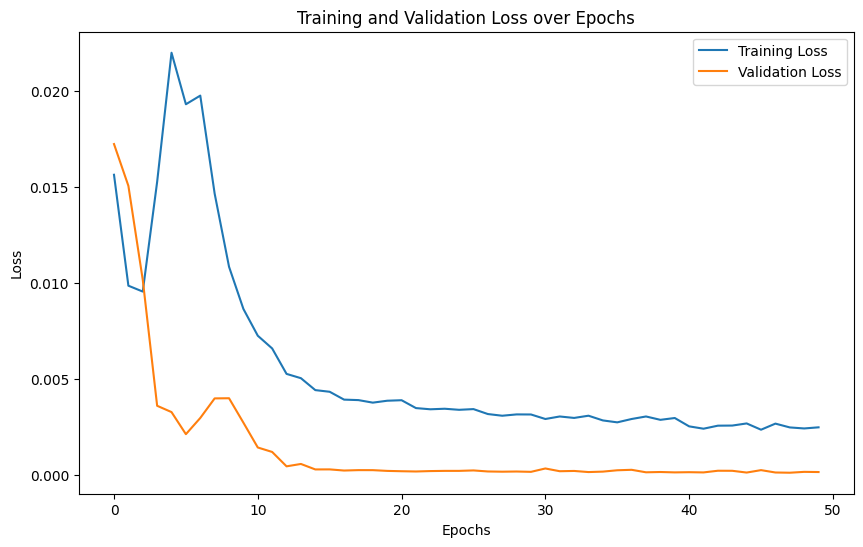

In [471]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction

42/42 [==============================] - 1s 4ms/step


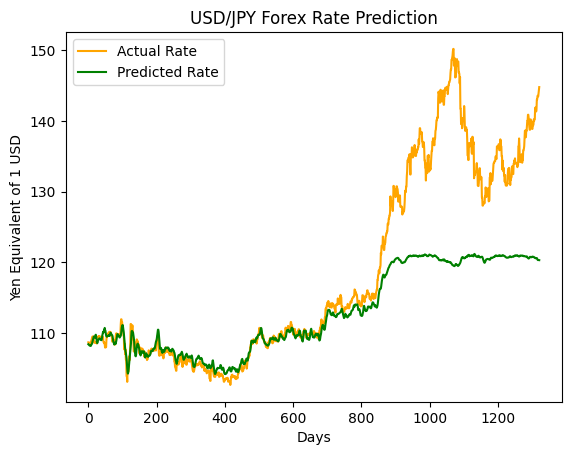

In [472]:
y_pred = model.predict(x_test)

# To invert the scaler, we create a placeholder array with the same shape as `scaled_features`.
placeholder_array_test = np.zeros((len(y_test), scaled_features.shape[1]))
placeholder_array_pred = np.zeros((len(y_pred), scaled_features.shape[1]))

# Insert the y_test and y_pred data into the last column of the placeholder arrays
placeholder_array_test[:,-1] = y_test[:,0]
placeholder_array_pred[:,-1] = y_pred[:,0]

# Invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(placeholder_array_test)[:,-1]
y_pred_orig = scaler.inverse_transform(placeholder_array_pred)[:,-1]

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Rate', color='orange')
plt.plot(y_pred_orig, label='Predicted Rate', color='green')

plt.title('USD/JPY Forex Rate Prediction')
plt.xlabel('Days')
plt.ylabel('Yen Equivalent of 1 USD')
plt.legend(loc='best')

plt.show()


Complete plot

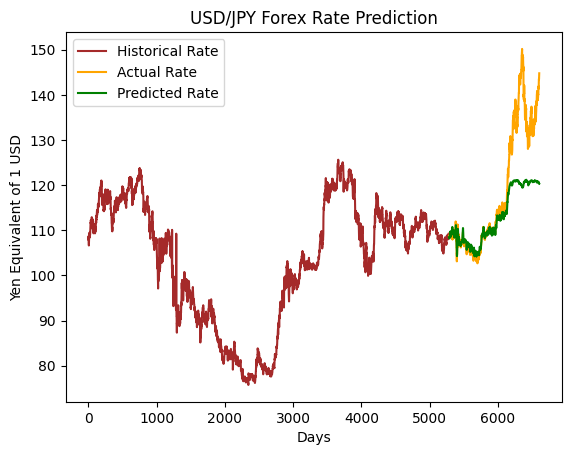

In [473]:
# Prepare a placeholder array for y_train for the inverse transformation
placeholder_array_train = np.zeros((len(y_train), scaled_features.shape[1]))
placeholder_array_train[:,-1] = y_train[:,0]
y_train_orig = scaler.inverse_transform(placeholder_array_train)[:,-1]

# Plot for the entire range of data
plt.plot(np.arange(0, len(y_train)), y_train_orig, color='brown', label='Historical Rate')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Rate')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Rate')

plt.title('USD/JPY Forex Rate Prediction')
plt.xlabel('Days')
plt.ylabel('Yen Equivalent of 1 USD')
plt.legend()
plt.show()


In [474]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 29, 29)            4408      
                                                                 
 dropout_84 (Dropout)        (None, 29, 29)            0         
                                                                 
 lstm_56 (LSTM)              (None, 29, 58)            20416     
                                                                 
 dropout_85 (Dropout)        (None, 29, 58)            0         
                                                                 
 lstm_57 (LSTM)              (None, 29)                10208     
                                                                 
 dropout_86 (Dropout)        (None, 29)                0         
                                                                 
 dense_28 (Dense)            (None, 1)               

In [475]:
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

print("Param:", seq_len, batch_size)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Param: 30 32
Mean Squared Error (MSE): 92.0307943135258
Root Mean Squared Error (RMSE): 9.593268176879338
Mean Absolute Error (MAE): 5.782575309039549
R-squared (R2) Score: 0.4895941701805233
